<a href="https://colab.research.google.com/github/LiucijaSvink/stroke_and_health_markers_prediction/blob/main/Analysis_and_prediction_of_stroke_and_other_physiological_markers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of stroke and other physiological markers

Stroke is one of the leading causes of death and a major cause of serious disability for adults. Americans spend an annual average of [$45.5 billion](https://washingtonnational.com/explore/why-insurance/how-to-cover-stroke-cost/#:~:text=The%20financial%20impact%20of%20stroke&text=According%20to%20the%20American%20Heart,and%20indirect%20costs%20of%20stroke.) on direct and indirect costs of stroke. 

Rehabilitation services and medication in the first year after stroke average to [$17,081](https://pubmed.ncbi.nlm.nih.gov/22120036/) in the USA. Patients have a much greater chance of surviving and preventing long-term brain damage if the patients receive treatment within the first [1-3 hours](https://integrisok.com/resources/on-your-health/2019/may/why-is-the-golden-hour-so-important-when-it-comes-to-stroke) after the stroke. Since fast stroke recognition and treatment are vital, it is important to educate those at risk and their relatives on how to behave in case of emergency.

In this notebook, we will be working on building a machine learning model aiming to predict whether the patient is likely to get a stroke. By having this knowledge, we will be able to determine which patients are at high stroke risk and doctors will be in a better position to advise them and their families on how to act in case of an emergency. 

In addition, we will investigate whether it is possible and to what extent to determine other physiological parameters: predicting hypertension, average glucose level, and BMI of the patient using the data that we have in the dataset taken from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). If these metrics could be estimated sufficiently well, the number of necessary tests at the clinics could be reduced.

## Preparations

We will start by installing packages and importing libraries necessary for the analysis. 

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from scipy import stats
from scipy.stats import levene, mannwhitneyu

from sklearn.model_selection import train_test_split, cross_validate, \
                                    RandomizedSearchCV, StratifiedKFold, KFold

from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import recall_score, average_precision_score, accuracy_score, \
                            precision_recall_curve, precision_score, r2_score, \
                            mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, \
                             GradientBoostingRegressor, RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from google.colab import drive
import numpy.ma as ma
import joblib

from xgboost import XGBClassifier, XGBRegressor, plot_importance
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

from typing import List, Tuple, Dict, TypeVar
from sklearn.base import RegressorMixin, TransformerMixin, ClassifierMixin

import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and inspect data

Let's see what data we have.

In [50]:
stroke_data = pd.read_csv('/content/drive/MyDrive/healthcare-dataset-stroke-data.csv')

stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


For easier data handling all column names will be converted to lowercase.

In [51]:
stroke_data.columns = stroke_data.columns.str.lower()
stroke_data = stroke_data.applymap(lambda s:s.lower() if type(s) == str else s)
stroke_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,male,67.0,0,1,yes,private,urban,228.69,36.6,formerly smoked,1
1,51676,female,61.0,0,0,yes,self-employed,rural,202.21,NaN,never smoked,1
2,31112,male,80.0,0,1,yes,private,rural,105.92,32.5,never smoked,1
3,60182,female,49.0,0,0,yes,private,urban,171.23,34.4,smokes,1
4,1665,female,79.0,1,0,yes,self-employed,rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,female,80.0,1,0,yes,private,urban,83.75,NaN,never smoked,0
5106,44873,female,81.0,0,0,yes,self-employed,urban,125.20,40.0,never smoked,0
5107,19723,female,35.0,0,0,yes,self-employed,rural,82.99,30.6,never smoked,0
5108,37544,male,51.0,0,0,yes,private,rural,166.29,25.6,formerly smoked,0


In [52]:
stroke_data.shape

(5110, 12)

The following variables were derived from our database to use for the analysis:

1) **id:** unique identifier

2) **gender:** "Male", "Female" or "Other"

3) **age:** age of the patient

4) **hypertension:** 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) **heart_disease:** 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) **ever_married:** "No" or "Yes"

7) **work_type:** "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) **residence_type:** "Rural" or "Urban"

9) **avg_glucose_level:** average glucose level in blood

10) **bmi:** body mass index

11) **smoking_status:** "formerly smoked", "never smoked", "smokes" or "Unknown" (the information is unavailable for this patient)

12) **stroke:** 1 if the patient had a stroke or 0 if not


We see that each patient has a unique identifier - id number. Based on the id, we will confirm that there are no duplicate patients in the dataset.

In [53]:
stroke_data.id.shape == stroke_data.id.unique().shape

True

There are no duplicate entries nor columns in the data. Next, we will check missing values.

In [54]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


One of the features, *BMI*, has some missing values. For visualization and statistical analysis purposes, these values will be ignored. When fitting models, missing values will be filled in with *SampleImputer*.

Next, we see that the data types do not always reflect the type of  data in the column. For example, stroke is a categorical variable with values 0 for not having stroke and 1 for having it, but is marked as a numeric integer feature. Furthermore, some features have *yes* and *no* for the feature indications. We will unify the encoding and change the type of the features to indicate which ones are categories. 

In [55]:
categorical_cols = ['gender', 'hypertension', 'heart_disease', 
                    'ever_married', 'work_type', 'residence_type', 
                    'smoking_status', 'stroke']

stroke_data[categorical_cols] = stroke_data[categorical_cols] \
                                           .replace({0: 'no', 1: 'yes'})
                                           
stroke_data[categorical_cols] = stroke_data[categorical_cols].astype('category')

Next, we will check the distribution of the variables which we are trying to predict: *stroke*, *hypertension*, *avg_glucose_level* and *BMI* variables. 

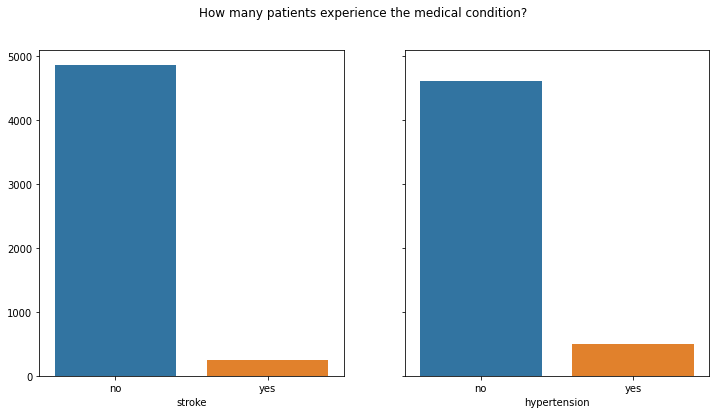

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey='row')
plt.suptitle('How many patients experience the medical condition?')

sns.countplot(data=stroke_data, x='stroke', ax=axes[0])
sns.countplot(data=stroke_data, x='hypertension', ax=axes[1])
axes[0].set_ylabel('')
axes[1].set_ylabel('');

The dataset seems to have far fewer examples of positive (1) rather than the negative (0) group. We will keep this in mind when building the models and evaluating their performance.

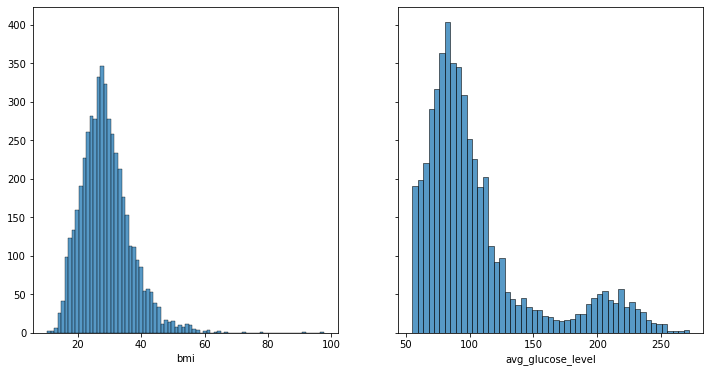

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey='row')

sns.histplot(data=stroke_data, x='bmi', ax=axes[0])
sns.histplot(data=stroke_data, x='avg_glucose_level', ax=axes[1])
axes[0].set_ylabel('')
axes[1].set_ylabel('');

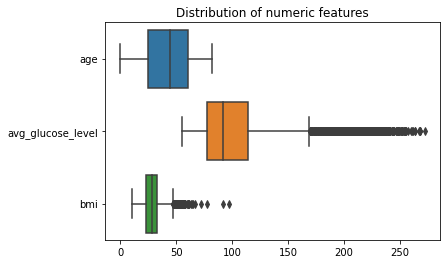

In [58]:
sns.boxplot(data=stroke_data.drop('id', axis=1), orient='h')
plt.title('Distribution of numeric features');

Looking at the distribution and boxplots of *BMI* values, we see that most of them cluster between 20 and 40 values, which is an expected range. BMI between 18-24 is considered normal and above 25 is overweight. There are some values close to 100 which are extreme but could be possible in obese patients. Therefore, we will not exclude them as invalid. 

Glucose levels have a bimodal distribution which is related to the fact that some people have diabetes (indicated by a glucose average level above 125).

Age values show that we have a good representation of age - from 0 to 80. 

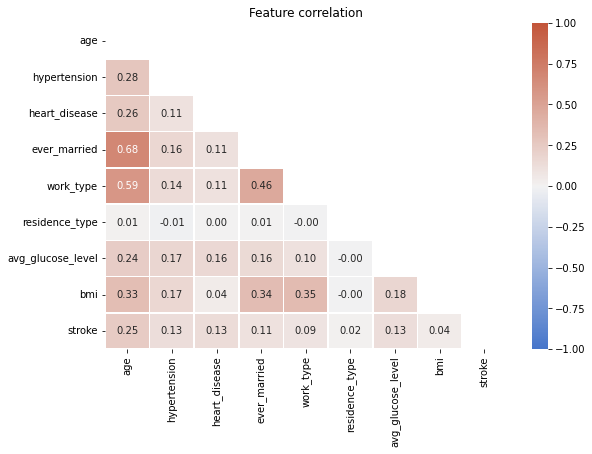

In [59]:
correlation = stroke_data.replace({'yes': 1, 'no': 0, 
                                   'rural': 0, 'urban':1,
                                   'never_worked': 0, 'children': 1,
                                   'govt_job': 2, 'private': 3, 
                                   'self-employed': 4, 'Unknown': 5, 
                                   'never smoked': 1, 'formerly smoked': 2, 
                                   'smokes': 3}).drop(columns='id').corr()

mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(255, 20, as_cmap=True)

plt.figure(figsize=(9, 6))
sns.heatmap(correlation,
            mask=mask, 
            cmap=cmap, 
            vmin=-1, 
            vmax=1,
            linewidths=.5, 
            annot=True, 
            fmt='.2f');

plt.title('Feature correlation');

Looking at the correlations, we see that there are no very high ones (above 0.7). Age seems to correlate with *ever_married* which is understandable - the older you are, the more likely you are to have ever been married.

## EDA

Now we move to the exploratory data analysis to explore the relationship between features. As we are interested in *stroke*, *hypertension*, *avg_glucose_level* and *BMI* predictions, we will create a visualization to see how other features are related to these outcomes. We will create a couple of functions for this.

In [60]:
#@title Defining plotting functions
def calculate_plot_proportion(data: pd.DataFrame, 
                              features: List[str], 
                              condition: str,
                              rows: int) -> None:
  '''Calculate the proportion of people that have a specified condition
  based on different features. Plot proportions in graphs'''
  fig, axes = plt.subplots(rows, len(features)//rows, figsize=(16, 11))
  axes = axes.flatten()
  fig.suptitle(f'Proportion of people having {condition} within different groups',
               fontsize=14);

  for feature, axis in zip(features, axes):
    data.loc[:, [condition, feature]].groupby([feature, condition]).size()
    crosstab = pd.crosstab(data[feature], data[condition], margins=True)
    crosstab['proportion'] = crosstab.iloc[:, 1] / crosstab['All'] * 100
    crosstab = crosstab.iloc[:-1, :].reset_index()
    sns.barplot(data=crosstab, x=feature, y='proportion', ax=axis)

    axis.tick_params(axis='x', rotation=40)
    axis.set_ylabel('Percentage (%)')

def plot_category_density(data: pd.DataFrame, 
                          feature: str, 
                          categories: List[str], 
                          rows: int) -> None:
  '''Plot categorical densities by subgroups of variables in a multi-plot'''
  fig, axes = plt.subplots(rows, len(categories)//rows, figsize=(18, 7))
  axes = axes.flatten()

  for category, axis in zip(categories, axes):
    sns.kdeplot(data=data, 
                x=feature, 
                hue=category, 
                common_norm=False, 
                ax=axis)
    
    axis.set_ylabel(' ')

For categorical features, we will plot the probability of having a condition as a proportion of people who had it in a particular group in comparison to an overall number of samples. Numeric variables will be plotted as distributions based on different categories.

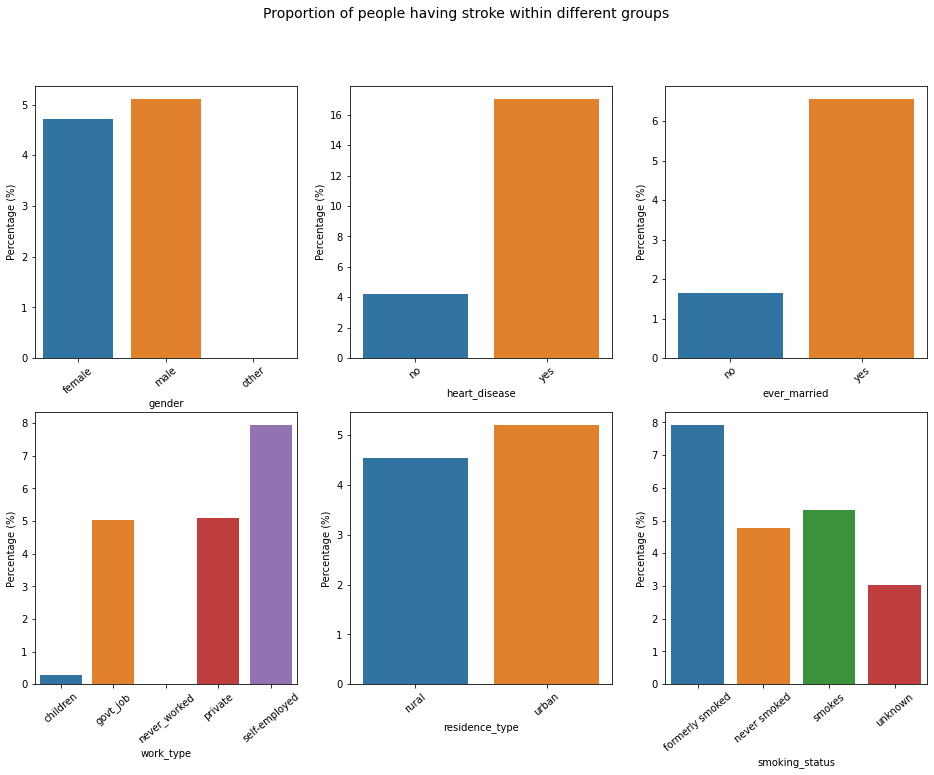

In [61]:
calculate_plot_proportion(stroke_data, ['gender','heart_disease', 
                                        'ever_married', 'work_type', 
                                        'residence_type', 'smoking_status', 
                                        'hypertension'], 'stroke', 2)

The plotted graph can be interpreted in the following manner: from all of the people falling within a certain category, e.g., male, how many of them had the specified condition? In this particular example, 5% of males had a stroke.

We see that males have strokes more often, and heart disease is more common in those who had a stroke. Surprisingly, those who ever married had a stroke more often. Self-employed and formerly smoker groups also have higher percentages of stroke occurrence.

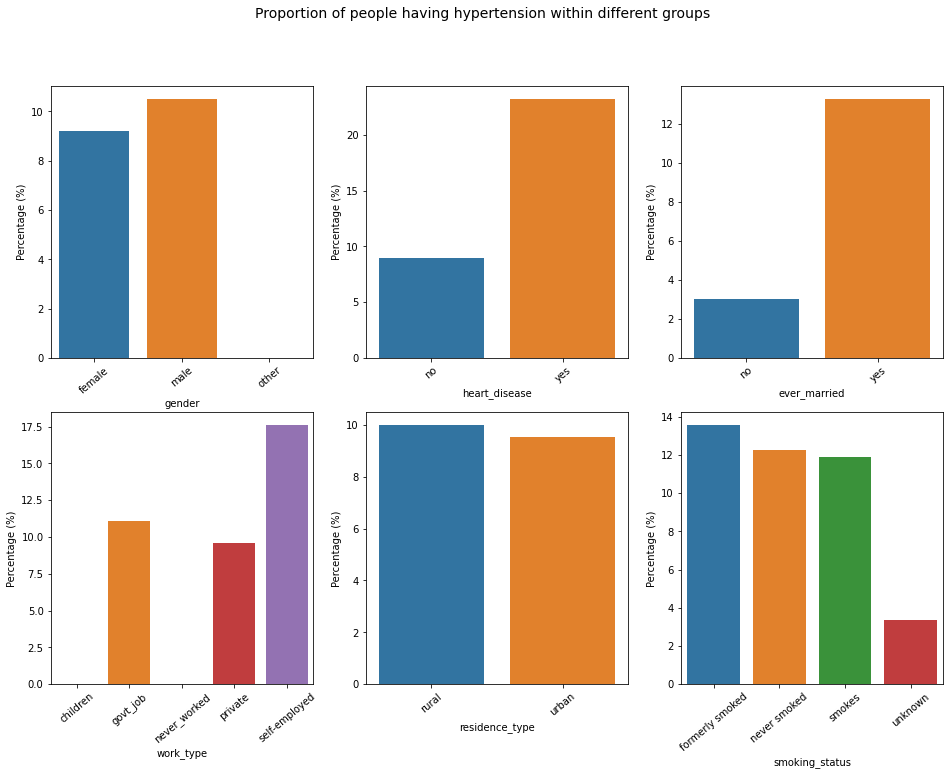

In [62]:
calculate_plot_proportion(stroke_data, ['gender','heart_disease', 
                                        'ever_married', 'work_type', 
                                        'residence_type', 'smoking_status', 
                                        'stroke'], 'hypertension', 2)

Far the chance of hypertension, we see very similar tendencies as for the stroke.

Similarly, we will plot the distribution of numeric targets of interest given the different categories. Note that the density functions are normalized to sum to 1 within the group.

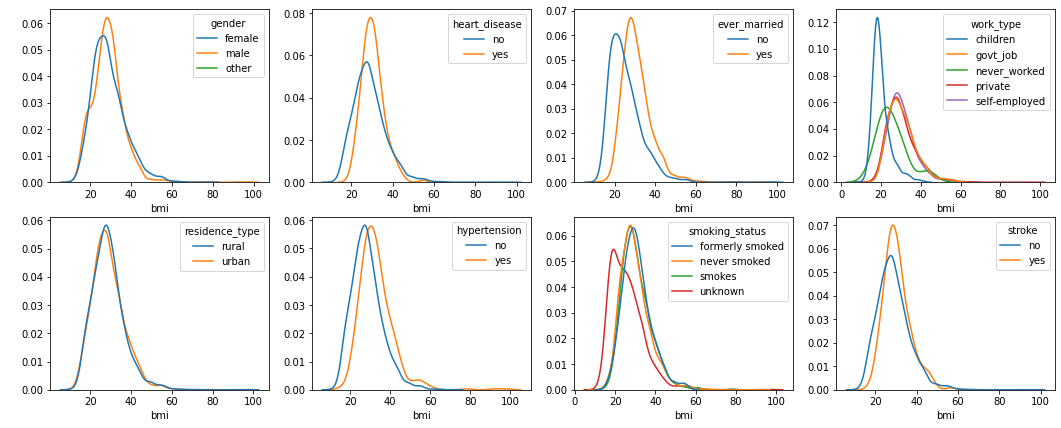

In [63]:
categories = ['gender','heart_disease', 'ever_married',
              'work_type', 'residence_type', 'hypertension',
              'smoking_status', 'stroke']

plot_category_density(stroke_data, 'bmi', categories, 2)

BMI distribution seems to be shifted to the right for those that were married and having hypertension. For other variables no very clear differences are visible.

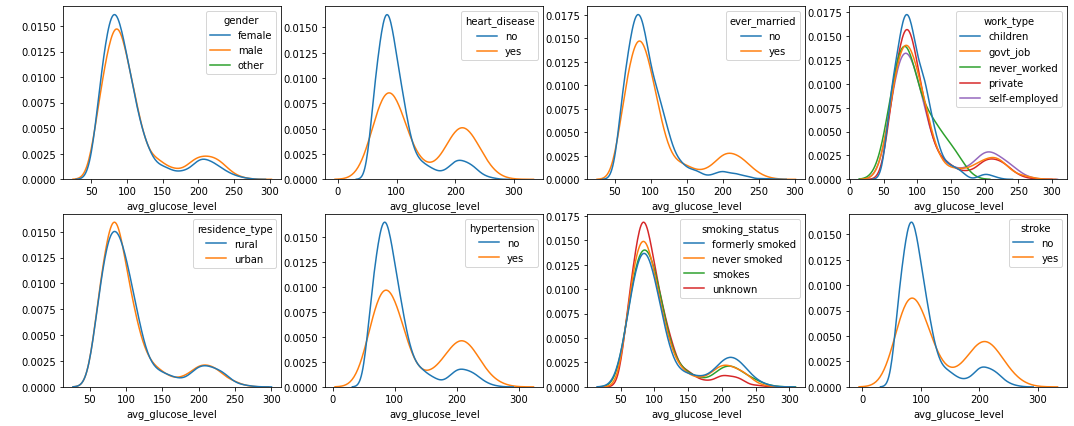

In [64]:
plot_category_density(stroke_data, 'avg_glucose_level', categories, 2)

The second glucose level distribution peak (indicating diabetes) seems to be higher for ever-married people, people with heart disease, hypertension and stroke. Which shows comorbidity between conditions. 

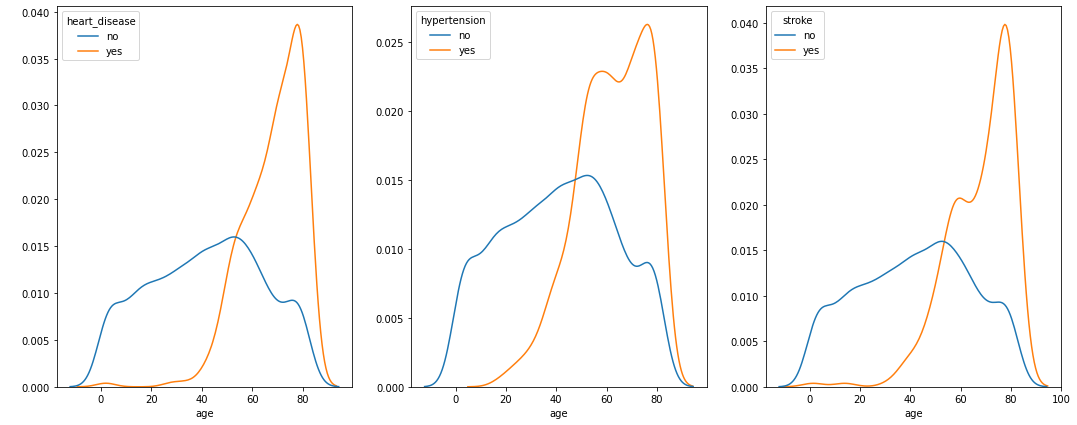

In [65]:
plot_category_density(stroke_data, 'age', ['heart_disease', 
                                           'hypertension', 'stroke'], 1)

Clearly, all three conditions are more prevalent in older people.

## Statistics

While in the distributions of *age* and *avg_glucose_level* differences are visible in the graphs, the difference in BMI is more subtle and harder to spot. Hence statistical test will be performed to test whether there is a significant difference between sample groups. 

Since there is an assumption about equal variances and we have different size groups, we will first check this assumption and choose a statistical test based on it.

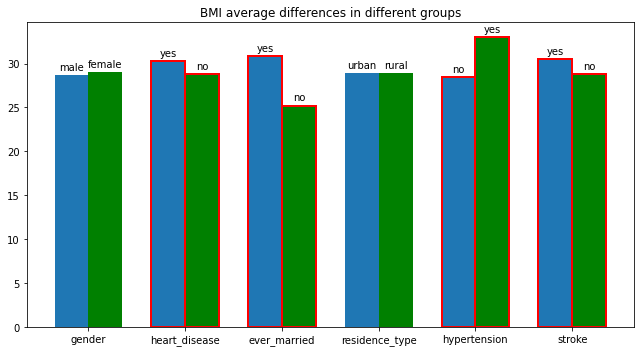

In [66]:
binary_categories = ['gender','heart_disease', 'ever_married', 
                   'residence_type', 'hypertension', 'stroke']

feature = 'bmi'

# Replace small group with nan since it is too small for comparison
stroke_data_stats = stroke_data.replace({'other': np.nan})

edge_color = []
means_group0 = []
means_group1 = []
group0_label = []
group1_label = []

for category in binary_categories:
  feature_stats = stroke_data_stats.loc[:, [category, feature]].dropna()
  groups = feature_stats[category].unique()

  group0 = feature_stats.loc[feature_stats[category] == groups[0], feature]
  group1 = feature_stats.loc[feature_stats[category] == groups[1], feature]
  
  group0_label.append(groups[0])
  group1_label.append(groups[1])
  
  outcome, p = levene(group0, group1)

  if p >= 0.05: # If variances of groups are equal
    statsvalue, pvalue = stats.ttest_ind(group0, group1)

  elif p < 0.05: # If variances of groups are not equal
    statsvalue, pvalue = mannwhitneyu(group0, group1)

  if pvalue <= 0.05/8:
    edge_color.append('red')
  else:
    edge_color.append('None')

  means_group0.append(np.mean(group0))
  means_group1.append(np.mean(group1))

fig, ax = plt.subplots(figsize=(9,5))

labels = binary_categories
x = np.arange(len(labels))
width = 0.35
rects0 = ax.bar(x - width/2, 
                means_group0, 
                width, 
                edgecolor=edge_color, 
                linewidth=2)

rects1 = ax.bar(x + width/2, 
                means_group1, 
                width,
                color='g',
                edgecolor=edge_color, 
                linewidth=2)

for bar, label in zip(rects0, group0_label):
   height = bar.get_height()
   ax.annotate(label,
      xy=(bar.get_x() + bar.get_width() / 2, height),
      xytext=(0, 3), 
      textcoords="offset points",
      ha='center', va='bottom')

for bar, label in zip(rects1, group1_label):
   height = bar.get_height()
   ax.annotate(label,
      xy=(bar.get_x() + bar.get_width() / 2, height),
      xytext=(0, 3), 
      textcoords="offset points",
      ha='center', va='bottom')

ax.set_title('BMI average differences in different groups')
ax.set_xticks(x)
ax.set_xticklabels(labels)

fig.tight_layout();

From the groups formed, the BMI does not seem to differ only between different genders and residence types.

## Stroke prediction

Using the dataset we will try to predict multiple variables. We will create general functions for creating pipelines, fitting and testing model performance as well as plotting the performance of different classifiers.

In [67]:
#@title Define functions for classification tasks
Predictor = TypeVar('Predictor')

def split_data(dataframe: pd.DataFrame,
               features: List[str], 
               output: str, 
               seed: int) -> Tuple[pd.DataFrame, ...]:
  '''Perform split of the data and return train and test datasets'''
  y = dataframe[output].replace({'yes': 1, 'no': 0})
  X = dataframe[features]

  if y.dtype == 'int64':
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        stratify=y,
                                                        random_state=seed)
  else:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=seed)

  return X_train, X_test, y_train, y_test

def make_preprocessing_pipeline(X: pd.DataFrame, 
                                numeric_encoder: TransformerMixin=None, 
                                category_encoder: TransformerMixin=None,
                                sample_imputer: TransformerMixin=None,
                                ) -> Pipeline:
  '''Make preprocessing pipeline using the defined input functions'''
  numeric = X.select_dtypes(include=np.number).columns.tolist()
  categorical = X.select_dtypes(include=['category']).columns.tolist()

  numeric_transformer = Pipeline([
      ('imputer', sample_imputer),
      ('std_scaler', numeric_encoder)
      ])

  categorical_transformer = category_encoder

  preprocessing_pipeline = ColumnTransformer(
      transformers=[
          ("numeric", numeric_transformer, numeric),
          ("categorical", categorical_transformer, categorical)
          ])

  return preprocessing_pipeline

def fit_evaluate_classifiers(preprocessing_pipeline: Pipeline, 
                             classifiers: List[ClassifierMixin], 
                             X: pd.DataFrame, 
                             y: pd.DataFrame) -> Dict:
  '''Fit preprocessing and model training pipeline to the data and get 
  cross-validation metrics for provided scoring list'''
  scoring = ['recall', 'precision', 'average_precision', 'accuracy']
  scores_dict = {'recall':[], 'precision':[], 'pr_auc':[], 'accuracy':[]}

  for classifier in classifiers:
    steps = [
        ('preprocess', preprocessing_pipeline),
        ('clf', classifier)
        ]

    pipeline = Pipeline(steps)

    cv = StratifiedKFold(n_splits=5)
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    scores_dict['recall'].append(round(np.mean(scores['test_recall']), 2))
    scores_dict['precision'].append(round(np.mean(scores['test_precision']), 2))
    scores_dict['pr_auc'].append(round(np.mean(scores['test_average_precision']), 2))
    scores_dict['accuracy'].append(round(np.mean(scores['test_accuracy']), 2))

  return scores_dict

def plot_performance(scores: Dict, 
                     label: List[str], 
                     c_min: int=0, 
                     c_max: int=1):
  '''Plot provided performance metrics. Metrics are plotted as rows and model
  labels as columns'''
  scoring = [*scores]

  temp = []
  for key in scores:
    temp.append(scores[key])
  
  performance = np.vstack(temp)

  plt.figure(figsize=(10, 4))
  sns.heatmap(performance, xticklabels=label, yticklabels = scoring, 
              vmin=c_min, vmax=c_max, annot=True, fmt='g')
    
  plt.xticks(rotation=80);

def predict_with_adjusted_threshold(model: Predictor, 
                                    threshold: int,
                                    X: pd.DataFrame, 
                                    y) -> None:
  '''Predict probabilities for the provided trained model and determine the 
  using adjusted threshold value. Prints out the model performance metrics'''
  y_predicted = (model.predict_proba(X)[:, 1] >= threshold).astype(int)

  print(f'Recall: {recall_score(y, y_predicted):.2f}')
  print(f'Precision: {precision_score(y, y_predicted):.2f}')
  print(f'PR_AUC: {average_precision_score(y, y_predicted):.2f}')
  print(f'Accuracy: {accuracy_score(y, y_predicted):.2f}')

### Baseline model

We will start with building models for stroke prediction. For the baseline model, we will use all other available features and try our multiple classifiers.

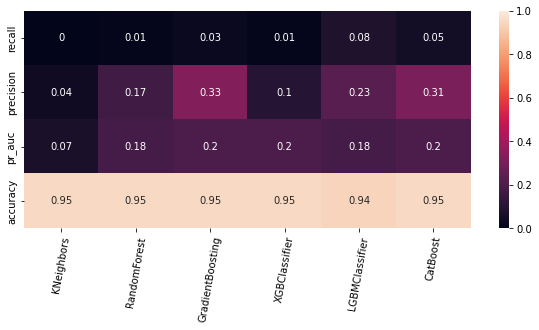

In [68]:
train_data = stroke_data[stroke_data.gender != 'other']

output = 'stroke'
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
            'smoking_status']

X_stroke_train, X_stroke_test, \
y_stroke_train, y_stroke_test = split_data(train_data, features, output, 42)

scaler = StandardScaler()
encoder = OrdinalEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_stroke_train, scaler, encoder, imputer)

classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0)
    ]

score_stroke = fit_evaluate_classifiers(preprocess, 
                                        classifiers,
                                        X_stroke_train, 
                                        y_stroke_train)

label_clf = [
    'KNeighbors',
    'RandomForest',
    'GradientBoosting',
    'XGBClassifier',
    'LGBMClassifier',
    'CatBoost']

plot_performance(score_stroke, label_clf)

We see 4 model performance metrics: recall, precision, precision-recall AUC (pr-AUC),  and accuracy. In this particular case it makes sense recall (coverage of the positive class) seems to be most important as the intervention we plan to apply - providing information on what to do in the case of stroke - is relatively cheap. On the other hand, we do not want to let the patients falsely worry about being likely to have a stroke when they are not. To take into account both measures, we will focus on pr-AUC during the optimizations. 

In the next sections, we will experiment with different model parameters and features to achieve better performance.



### Categorical Imputer

First, we are going to try out different categorical feature encoding types to see whether it affects model performance.

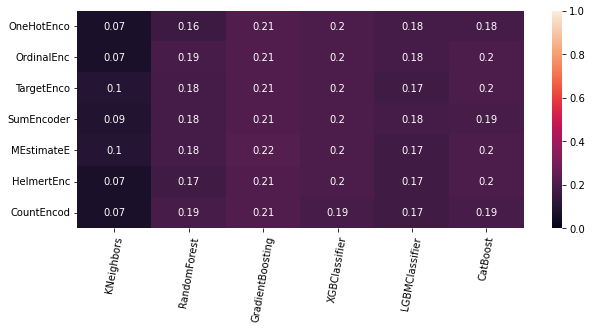

In [69]:
encoders = [
    OneHotEncoder(),
    OrdinalEncoder(),
    TargetEncoder(),
    SumEncoder(),
    MEstimateEncoder(),
    HelmertEncoder(), 
    CountEncoder()
    ]

encoder_dict={}

scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')

for encoder in encoders: 
  preprocess = make_preprocessing_pipeline(X_stroke_train, scaler,
                                           encoder, imputer)
  
  stroke_score_enc = fit_evaluate_classifiers(preprocess, 
                                              classifiers,
                                              X_stroke_train, 
                                              y_stroke_train)

  name = str(encoder)[:10]
  encoder_dict[name] = stroke_score_enc['pr_auc']

plot_performance(encoder_dict, label_clf)

There is very little variation in pr-AUC scores depending on the classifier. We will proceed with the MEstimate Encoder as it seems to be working rather well for all models.

### Feature engineering and selection

In [70]:
#@title Define mutual information functions
def make_mi_scores(X: pd.DataFrame, y: pd.DataFrame) -> None:
  '''Taking input matrix X and output variable y, calculate the mutual 
  information scores'''
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
      X[colname], _ = X[colname].factorize()
  # All discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, 
                                      discrete_features=discrete_features, 
                                      random_state=0)
  
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

def plot_mi_scores(scores: pd.Series) -> None:
  '''Plot the mutual information scores'''
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.title("Mutual Information Scores")

Next, we will try to create additional features to improve the performance of the models. We will create some features based on domain knowledge.

* The chance of having a stroke until age 45 is around 0.6% and doubles every 10 years after that age (see [1](https://pubmed.ncbi.nlm.nih.gov/24324935/#&gid=article-figures&pid=figure-11-uid-10) and [2](https://www.cdc.gov/stroke/risk_factors.htm)). Therefore, we will create a feature that assigns 0.6 value to all people below age 45 exponentially grows for older people.  

In [71]:
train_data_add = train_data
train_data_add['stroke_prob'] = 0.6 * 2 ** ((train_data_add['age']-45)/10)

mask_age = train_data_add['age'] < 45
train_data_add.loc[mask_age, 'stroke_prob'] = 0.6

* Obesity is associated with hypertension and stroke risk([3](https://www.obesityaction.org/wp-content/uploads/Obesity-and-Stroke-Fact-Sheet.pdf)). Therefore, we will create 5 categories from BMI: underweight (<18), normal (18-24.9), overweight (25-29.9), obese (30-34.9) and extremely obese (35<).

In [72]:
train_data_add['bmi_category'] = pd.cut(x=train_data_add['bmi'], 
                                        bins=[0, 18, 25, 30, 35, 120], 
                                        labels=['1', '2', '3', '4', '5'])

* Similarly, diabetes is a risk factor for developing both hypertension and stroke. People having higher than 125 mg/dL are considered diabetic. Based on this threshold, we will create column diabetes with 0 and 1 where 1 will mean they have diabetes. 

In [73]:
mask_diabetes = train_data_add.avg_glucose_level >= 126

train_data_add['diabetes'] = 0
train_data_add.loc[mask_diabetes, 'diabetes'] = 1

* Medical conditions we have described in the dataset, in general, have comorbidity. We will sum the available categorical conditions (excluding the target variable) where 1 means the person has the condition. 

In [74]:
train_data_add['condition_sum'] = train_data_add.hypertension.replace({'yes': 1, 'no': 0}) \
                                  + train_data_add.heart_disease.replace({'yes': 1, 'no': 0}) \
                                  + train_data_add.diabetes \
                                  + pd.to_numeric(train_data_add.bmi_category)

categorical_col = ['diabetes']
train_data_add[categorical_col] = train_data_add[categorical_col].astype('category')

We will use the newly created features to build the models.

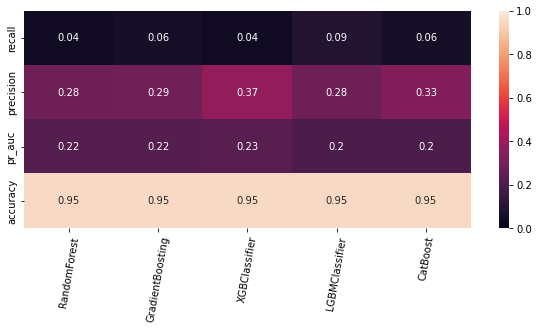

In [75]:
output = 'stroke'

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
            'smoking_status', 'stroke_prob', 'bmi_category', 'diabetes',
            'condition_sum']

X_train_stroke_add, X_test_stroke_add, \
y_train_stroke_add, y_test_stroke_add = split_data(train_data_add, 
                                                   features, output, 42)
scaler = StandardScaler()
encoder = MEstimateEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_train_stroke_add, scaler, 
                                         encoder, imputer)

classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0)
    ]

label_clf = [
    'RandomForest',
    'GradientBoosting',
    'XGBClassifier',
    'LGBMClassifier',
    'CatBoost'
    ]

score_stroke_add = fit_evaluate_classifiers(preprocess, 
                                            classifiers,
                                            X_train_stroke_add, 
                                            y_train_stroke_add)

plot_performance(score_stroke_add, label_clf)

The pr-AUC and other metrics increased a bit for most of the models.
Let's also look at the Mutual Information (MI) values of the features.

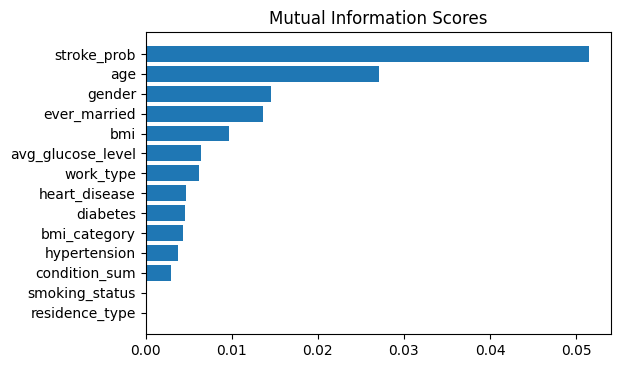

In [76]:
X_train_stroke_add.bmi = X_train_stroke_add.bmi\
                        .fillna(X_train_stroke_add['bmi'].median())

X_train_stroke_add.bmi_category = X_train_stroke_add.bmi_category \
                                 .fillna(X_train_stroke_add['bmi_category'] \
                                         .mode())

X_train_stroke_add.condition_sum = X_train_stroke_add.condition_sum \
                                   .fillna(X_train_stroke_add['condition_sum'] \
                                           .median())

mi_scores = make_mi_scores(X_train_stroke_add, y_train_stroke_add)

plt.figure(dpi=100, figsize=(6, 4))
plot_mi_scores(mi_scores)

It looks like stroke probability as well as age and gender seem to be important features. This corresponds to the literature which says that stroke is more common in older people and men. We will remove a couple (4) of the features with the least MI.

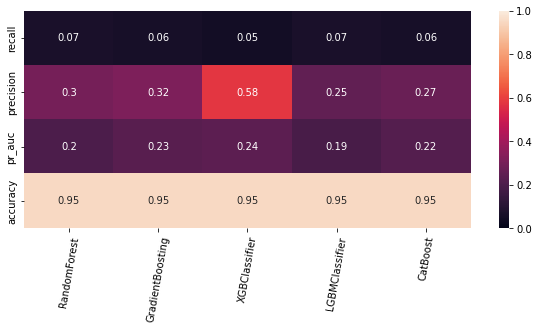

In [77]:
output = 'stroke'

features = ['gender', 'age', 'heart_disease', 'ever_married', 'work_type', 
            'avg_glucose_level', 'bmi', 'stroke_prob', 'bmi_category', 'diabetes']

X_train_stroke_add, X_test_stroke_add, \
y_train_stroke_add, y_test_stroke_add = split_data(train_data_add, 
                                                   features, output, 42)
scaler = StandardScaler()
encoder = MEstimateEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_train_stroke_add, scaler, 
                                         encoder, imputer)

classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0)
    ]

score_stroke_add = fit_evaluate_classifiers(preprocess, 
                                            classifiers,
                                            X_train_stroke_add, 
                                            y_train_stroke_add)

label_clf = [
    'RandomForest',
    'GradientBoosting',
    'XGBClassifier',
    'LGBMClassifier',
    'CatBoost'
    ]

plot_performance(score_stroke_add, label_clf)

The scores improved a bit and one of the models experience a notable increase in precision. We will keep the reduced number of features for further model optimization.

### Balancing classes

We will try to balance the examples of classes as we saw a significant class disbalance at the beginning of the notebook. This will be done by adjusting the class weights of the models. Since the GradientBoosting classifier does not provide this option by default and did not show a superior performance so far, we will not continue with this model further.

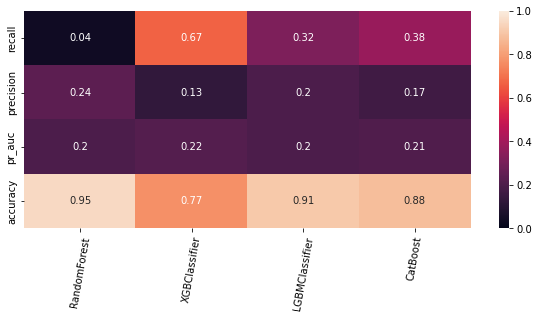

In [78]:
classes = np.unique(y_train_stroke_add)
weights = compute_class_weight(class_weight='balanced', 
                               classes=classes, y=y_train_stroke_add)

class_weights = dict(zip(classes, weights))

classifiers = [
    RandomForestClassifier(class_weight=class_weights),
    XGBClassifier(scale_pos_weight=weights[1]/weights[0]),
    LGBMClassifier(is_unbalance=True),
    CatBoostClassifier(class_weights=class_weights, verbose=0)
    ]

scaler = StandardScaler()
encoder = MEstimateEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_train_stroke_add, scaler, 
                                         encoder, imputer)

score_stroke_add = fit_evaluate_classifiers(preprocess, 
                                            classifiers,
                                            X_train_stroke_add, 
                                            y_train_stroke_add)

label_clf = [
    'RandomForest',
    'XGBClassifier',
    'LGBMClassifier',
    'CatBoost'
    ]

plot_performance(score_stroke_add, label_clf)

### Hyperparameter tuning

For the models trained before, we used default hyperparameters. In this section, we will tune each model's hyperparameters to improve models.

In [79]:
#@title Define hyperparameter optimization and threshold functions
def fit_evaluate_hyperparameters(preprocessing_pipeline: Pipeline, 
                                 search_space: Dict, 
                                 X: pd.DataFrame, 
                                 y: pd.DataFrame) -> Predictor:
  '''Create, fit and cross-validate different model hyperparameters using 
  specified preprocessing pipeline and search space'''

  steps = [
      ('preprocess', preprocessing_pipeline),
      ('classifier', RandomForestClassifier())
      ]

  pipeline = Pipeline(steps)

  cv = StratifiedKFold(n_splits=5)

  random_search = RandomizedSearchCV(pipeline, search_space,
                                     cv=cv, scoring='average_precision',
                                     n_jobs=-1)

  model = random_search.fit(X, y)
  print(model.best_estimator_.get_params()['classifier'])

  print(f'Recall: {recall_score(y, model.predict(X)):.2f}')
  print(f'Precision: {precision_score(y, model.predict(X)):.2f}')
  print(f'PR_AUC: {average_precision_score(y, model.predict(X)):.2f}')
  print(f'Accuracy: {accuracy_score(y, model.predict(X)):.2f}')

  return model.best_estimator_

def get_threshold(model: Predictor, 
                  X: pd.DataFrame, 
                  y: pd.DataFrame, 
                  recall_threshold: int = 0.8) -> int:
  '''Given the provided recall threshold, determine and return the decision 
  boundary threshold to use for atributing a sample to class 0 or 1''' 
  y_predicted = model.predict_proba(X)[:, 1]
  precision, recall, thresholds = precision_recall_curve(y, y_predicted)

  ix = np.argmax(ma.masked_array(precision, mask=recall < recall_threshold))
  threshold = thresholds[ix]

  plt.plot(recall, precision, marker='.', label='model performance')
  plt.scatter(recall[ix], precision[ix], marker='o', 
              color='red', label='threshold')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Best performing model precision-recall curve')
  plt.legend();

  return threshold

We will perform hyperparameter search and threshold analysis on the final best model. In particular, after hyperparameter tuning, using left-out validation data we will plot the pr-AUC curve and select a corresponding threshold which will be slightly biased towards higher recall values. The threshold will be set to 0.8 of recall.

In [80]:
search_space = [
    {'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [100, 1000, 2000],
    'classifier__max_features': ['sqrt', None, 0.2, 0.4], 
    'classifier__criterion': ['gini', 'entropy'], 
    'classifier__min_samples_leaf': [1, 2, 4, 8], 
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__class_weight': [{0:1,1:5}, {0:1,1:10}, {0:1,1:19.5},
                                {0:1,1:25}]},
  
  {'classifier': [XGBClassifier()],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__max_depth': [2, 4, 8, 10],
    'classifier__min_child_weight': [1, 2, 5, 10],
    'classifier__scale_pos_weight': [5, 10, 20], 
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__gamma': [0.001, 0.01, 0.1, 0.3],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0.01, 0.1, 1, 10, 100], 
    'classifier__reg_lambda': [0.01, 0.1, 1, 10, 100], 
    'classifier__max_delta_step': [1, 2, 5, 10], 
    'classifier__eval_metric': [None, 'binary:logistic']},

  {'classifier': [LGBMClassifier()],
    'classifier__n_estimators': [100, 1000, 2000],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__boosting_type': ['gbdt', 'dart', 'goss'], 
    'classifier__objective': [None, 'binary'], 
    'classifier__is_unbalanced':[True]},
    
  {'classifier': [CatBoostClassifier()],
  'classifier__iterations': [100, 1000, 2000], 
  'classifier__depth': [2, 4, 8, 10],
  'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
  'classifier__random_strength': [0.001, 0.01, 0.1, 1, 10],
  'classifier__bagging_temperature': [0.01, 0.1, 0.3, 0.5, 1],
  'classifier__l2_leaf_reg': [2, 5, 10, 20],
  'classifier__class_weights':[class_weights]} 
  ]

X_train_stroke_hyper, X_val_stroke_hyper, \
y_train_stroke_hyper, y_val_stroke_hyper = train_test_split(X_train_stroke_add, 
                                                            y_train_stroke_add,
                                                            test_size=0.15, 
                                                            stratify=y_train_stroke_add, 
                                                            random_state=42)

best_stroke_model = fit_evaluate_hyperparameters(preprocess, search_space, 
                                                  X_train_stroke_hyper, 
                                                  y_train_stroke_hyper)

XGBClassifier(colsample_bytree=0.8, gamma=0.3, max_delta_step=10, max_depth=8,
              min_child_weight=10, reg_alpha=0.1, reg_lambda=100,
              scale_pos_weight=5, subsample=0.8)
Recall: 0.54
Precision: 0.40
PR_AUC: 0.24
Accuracy: 0.94


Above are the hyperparameters of the optimal model based on random search.

Recall: 0.83
Precision: 0.16
PR_AUC: 0.14
Accuracy: 0.77


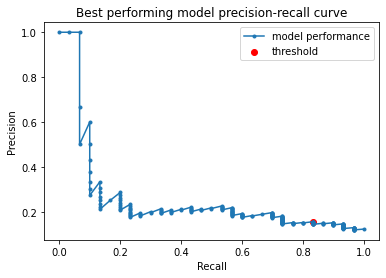

In [81]:
stroke_threshold = get_threshold(best_stroke_model, X_val_stroke_hyper,
                                 y_val_stroke_hyper, recall_threshold=0.80)

predict_with_adjusted_threshold(best_stroke_model, stroke_threshold,
                                X_val_stroke_hyper, y_val_stroke_hyper)

The final model will be saved for the deployment.

In [82]:
joblib.dump(best_stroke_model, 'stroke_model.pkl')
stroke_threshold

0.23800959

Finally, the model performance will be evaluated using the left-out test set. In addition, for a better understanding of important factors, we will show feature importance for the final model.

Recall: 0.76
Precision: 0.15
PR_AUC: 0.13
Accuracy: 0.78


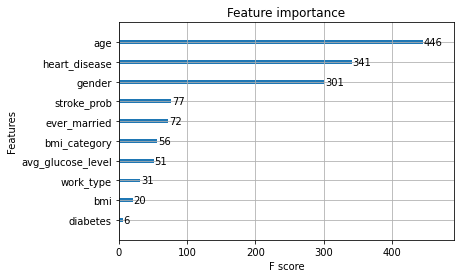

In [83]:
predict_with_adjusted_threshold(best_stroke_model, 
                                stroke_threshold, 
                                X_test_stroke_add,
                                y_test_stroke_add)

best_stroke_model['classifier'].get_booster().feature_names = features
plot_importance(best_stroke_model['classifier'].get_booster());

The recall score is relatively high and the most important features seem to be age, heart disease and gender. These features make sense and, therefore, provide some confidence about the model.

## Hypertension prediction

For hypertension prediction, we will follow a similar training procedure as for stroke.

### Baseline model

Since hypertension is also an imbalanced problem, we will immediately assign different weights to the classes to solve this problem.

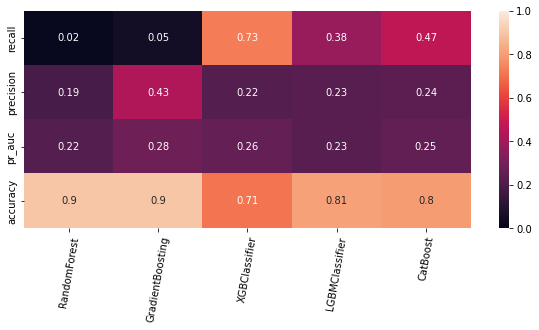

In [84]:
output = 'hypertension'

features = ['gender', 'age', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke_prob', 'bmi_category', 'diabetes']

X_train_hypertension, X_test_hypertension, \
y_train_hypertension, y_test_hypertension = split_data(train_data_add, 
                                                       features, output, 42)

classes = np.unique(y_train_hypertension)
weights = compute_class_weight(class_weight='balanced', 
                               classes=classes, 
                               y=y_train_hypertension)

class_weights = dict(zip(classes, weights))

scaler = StandardScaler()
encoder = MEstimateEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_train_hypertension, scaler, 
                                         encoder, imputer)

classifiers = [
    RandomForestClassifier(class_weight=class_weights),
    GradientBoostingClassifier(),
    XGBClassifier(scale_pos_weight=weights[1]/weights[0]),
    LGBMClassifier(is_unbalance=True),
    CatBoostClassifier(class_weights=class_weights, verbose=0)
    ]

label_clf = [
    'RandomForest',
    'GradientBoosting',
    'XGBClassifier',
    'LGBMClassifier',
    'CatBoost'
    ]

score_hypertension = fit_evaluate_classifiers(preprocess, 
                                              classifiers,
                                              X_train_hypertension, 
                                              y_train_hypertension)

plot_performance(score_hypertension, label_clf)

### Feature selection

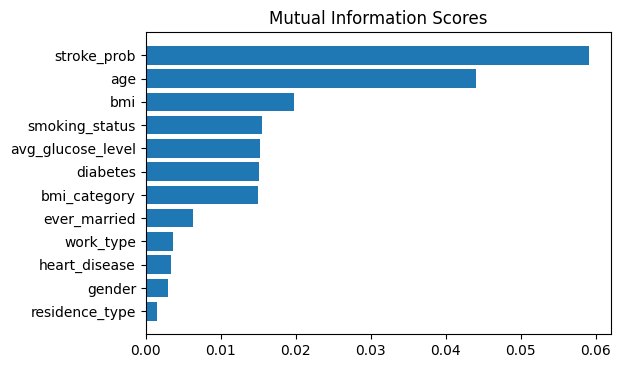

In [85]:
X_train_hypertension.bmi = X_train_hypertension.bmi.fillna(X_train_hypertension['bmi'].median())
X_train_hypertension.bmi_category = X_train_hypertension.bmi_category.fillna(X_train_hypertension['bmi_category'].mode())

mi_scores = make_mi_scores(X_train_hypertension, y_train_hypertension)

plt.figure(dpi=100, figsize=(6, 4))
plot_mi_scores(mi_scores)

Interestingly, the same factor of age which is used for stroke probability seems to be influential here as well. In this case, however, gender and residence type seems to matter the least. We will remove 4 least important features.

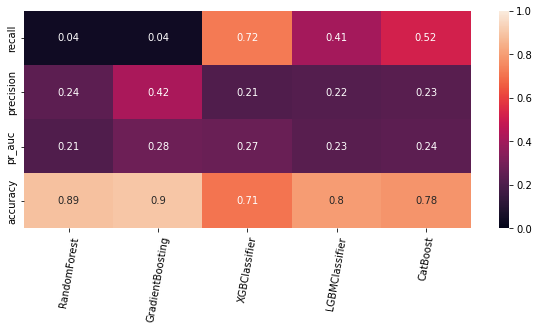

In [86]:
output = 'hypertension'

features = ['age',  'ever_married', 'avg_glucose_level', 'bmi',
            'smoking_status', 'stroke_prob', 'bmi_category', 'diabetes']

X_train_hypertension, X_test_hypertension, \
y_train_hypertension, y_test_hypertension = split_data(train_data_add, 
                                                       features, output, 42)
scaler = StandardScaler()
encoder = MEstimateEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_train_hypertension, scaler, 
                                         encoder, imputer)

classifiers = [
    RandomForestClassifier(class_weight=class_weights),
    GradientBoostingClassifier(),
    XGBClassifier(scale_pos_weight=weights[1]/weights[0]),
    LGBMClassifier(is_unbalance=True),
    CatBoostClassifier(class_weights=class_weights, verbose=0)
    ]

score_hypertension = fit_evaluate_classifiers(preprocess, 
                                              classifiers,
                                              X_train_hypertension, 
                                              y_train_hypertension)

plot_performance(score_hypertension, label_clf)

Some of the models are performing a bit better.
Now, we will optimize the model hyperparameters and perform threshold analysis.

### Hyperparameter tuning


In [87]:
search_space = [
    {'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [100, 1000, 2000],
    'classifier__max_features': ['sqrt', None, 0.2, 0.4], 
    'classifier__criterion': ['gini', 'entropy'], 
    'classifier__min_samples_leaf': [1, 2, 4, 8], 
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__class_weight': [{0:1,1:5}, {0:1,1:10}, {0:1,1:19.5}, {0:1,1:25}]},
  
  {'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': [100, 1000, 2000],
    'classifier__max_features': ['sqrt', None, 0.2, 0.4], 
    'classifier__criterion': ['friedman_mse', 'squared_error'], 
    'classifier__min_samples_leaf': [1, 2, 4, 8], 
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 1.0]},
  
  {'classifier': [XGBClassifier()],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__max_depth': [2, 4, 8, 10],
    'classifier__min_child_weight': [1, 2, 5, 10],
    'classifier__scale_pos_weight': [5, 10, 20], 
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__gamma': [0.001, 0.01, 0.1, 0.3],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0.01, 0.1, 1, 10, 100], 
    'classifier__reg_lambda': [0.01, 0.1, 1, 10, 100], 
    'classifier__max_delta_step': [1, 2, 5, 10], 
    'classifier__eval_metric': [None, 'binary:logistic']},
  
  {'classifier': [LGBMClassifier()],
    'classifier__n_estimators': [100, 1000, 2000],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__boosting_type': ['gbdt', 'dart', 'goss'], 
    'classifier__objective': [None, 'binary'], 
    'classifier__is_unbalanced':[True]},
  
  {'classifier': [CatBoostClassifier()],
  'classifier__iterations': [100, 1000, 2000], 
  'classifier__depth': [2, 4, 8, 10],
  'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
  'classifier__random_strength': [0.001, 0.01, 0.1, 1, 10],
  'classifier__bagging_temperature': [0.01, 0.1, 0.3, 0.5, 1],
  'classifier__l2_leaf_reg': [2, 5, 10, 20],
  'classifier__class_weights':[class_weights]}
  ]

X_train_hypertension_hyper, \
X_val_hypertension_hyper, \
y_train_hypertension_hyper, \
y_val_hypertension_hyper = train_test_split(X_train_hypertension, 
                                            y_train_hypertension,
                                            test_size=0.15, 
                                            stratify=y_train_hypertension, 
                                            random_state=42)

best_hyper_model = fit_evaluate_hyperparameters(preprocess, search_space, 
                                                X_train_hypertension_hyper, 
                                                y_train_hypertension_hyper)

XGBClassifier(colsample_bytree=0.6, gamma=0.1, learning_rate=0.3,
              max_delta_step=1, max_depth=2, min_child_weight=5, reg_alpha=100,
              reg_lambda=0.01, scale_pos_weight=5, subsample=0.6)
Recall: 0.55
Precision: 0.28
PR_AUC: 0.20
Accuracy: 0.82


Recall: 0.92
Precision: 0.20
PR_AUC: 0.19
Accuracy: 0.64


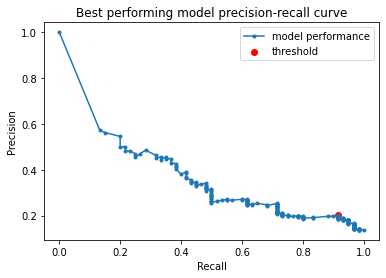

In [88]:
hyper_threshold = get_threshold(best_hyper_model, X_val_hypertension_hyper, 
                                y_val_hypertension_hyper, recall_threshold=0.8)

predict_with_adjusted_threshold(best_hyper_model, hyper_threshold,
                                X_val_hypertension_hyper, 
                                y_val_hypertension_hyper)

Recall: 0.83
Precision: 0.18
PR_AUC: 0.17
Accuracy: 0.61


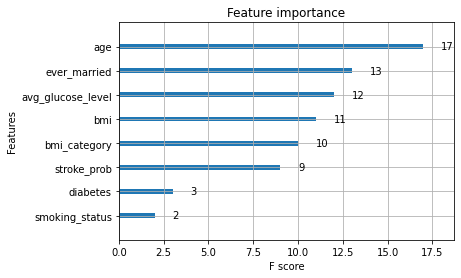

In [89]:
predict_with_adjusted_threshold(best_hyper_model, hyper_threshold, 
                                X_test_hypertension, y_test_hypertension)

best_hyper_model['classifier'].get_booster().feature_names = features
plot_importance(best_hyper_model['classifier'].get_booster());

We got 0.81 recall and 0.2 precision. Surprisingly, the model chose the feature of ever being married as the most important. Perhaps other factors, confounding this one, could determine the likelihood of hypertension (more worries when having a family, less time for exercising) and should be investigated further.

## Regression tasks: average glucose level and BMI prediction
We also would like to predict the numeric values, in particular, *BMI* and *avg_glucose_level* using some of the features that we have.

In [109]:
#@title Define regression functions
def fit_evaluate_regressors(preprocessing_pipeline: Pipeline, 
                            regressors: List[RegressorMixin],
                            X: pd.DataFrame, 
                            y: pd.DataFrame) -> Dict:
  '''With specified pipeline and regressors, fit and cross-validate models. 
  Return results in a dictionary'''
  scoring = ['r2', 'neg_root_mean_squared_error']
  scores_dict = {'r2':[], 'RMSE':[]}

  for regressor in regressors:
    steps = [
            ('preprocess', preprocessing_pipeline),
            ('reg', regressor)
            ]

    pipeline = Pipeline(steps)

    cv = KFold(n_splits=5)
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv)

    scores_dict['r2'].append(round(np.mean(scores['test_r2']), 2))
    scores_dict['RMSE'].append(round(np.mean(scores['test_neg_root_mean_squared_error']), 2))

  return scores_dict

def fit_predict_regressor(preprocessing_pipeline: Pipeline, 
                          regressor: Predictor,
                          X_train: pd.DataFrame, y_train: pd.DataFrame,
                          X_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
  '''With specified pipeline and regressor, fit regression on full training set
  and predict test set. Output R2 and MSE scores'''
  steps = [
          ('preprocess', preprocessing_pipeline),
          ('reg', regressor)
          ]

  pipeline = Pipeline(steps)

  model = pipeline.fit(X_train, y_train)
  y_predicted = model.predict(X_test)

  print(f'R2 score: {r2_score(y_test, y_predicted):.2f}')
  print(f'RMSE: {mean_squared_error(y_test, y_predicted, squared=False):.2f}')

### Average glucose level prediction

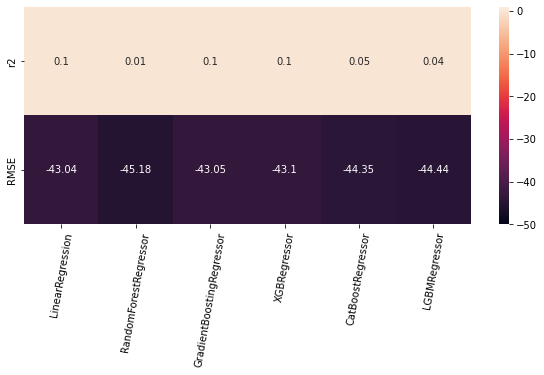

In [110]:
output = 'avg_glucose_level'

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'residence_type', 'bmi',
            'smoking_status', 'stroke_prob', 'bmi_category']

X_train_glucose, X_test_glucose, \
y_train_glucose, y_test_glucose = split_data(train_data_add,
                                             features, output, 42)

scaler = StandardScaler()
encoder = MEstimateEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_train_glucose, scaler, 
                                         encoder, imputer)

regressors = [
    LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(objective ='reg:squarederror'),
    CatBoostRegressor(verbose=0),
    LGBMRegressor()]

score_glucose = fit_evaluate_regressors(preprocess, regressors, 
                                        X_train_glucose, y_train_glucose)

label_reg = [
    'LinearRegression',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'XGBRegressor',
    'CatBoostRegressor',
    'LGBMRegressor',
    ]

plot_performance(score_glucose, label_reg, c_min=-50, c_max=1)

LInear regression seems to be perfroming best. We will retrain these models on the full training set and check the performance on the testing set.

In [111]:
fit_predict_regressor(preprocess,
                      LinearRegression(), 
                      X_train_glucose, y_train_glucose, 
                      X_test_glucose, y_test_glucose)

R2 score: 0.07
RMSE: 43.04


### BMI value prediction
Next, we will similarly predict the *BMI* outcome.

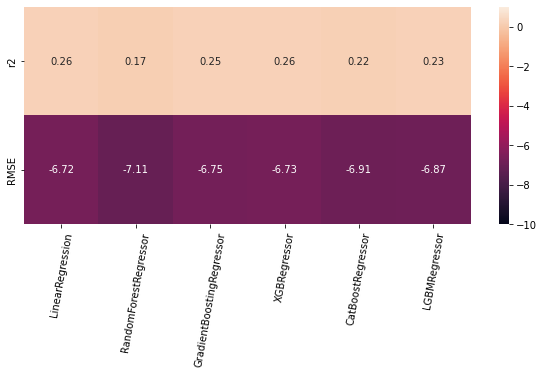

In [112]:
stroke_data_bmi = train_data_add.dropna()
output = 'bmi'

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'residence_type', 'avg_glucose_level',
            'smoking_status', 'stroke_prob', 'diabetes']

X_train_bmi, X_test_bmi, \
y_train_bmi, y_test_bmi = split_data(stroke_data_bmi, features, output, 42)

scaler = StandardScaler()
encoder = MEstimateEncoder()
imputer = SimpleImputer(strategy='median')

preprocess = make_preprocessing_pipeline(X_train_bmi, scaler, 
                                         encoder, imputer)

regressors = [
    LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(objective ='reg:squarederror'),
    CatBoostRegressor(verbose=0),
    LGBMRegressor(),
    ]

score_bmi = fit_evaluate_regressors(preprocess, regressors, 
                                    X_train_bmi, y_train_bmi)

plot_performance(score_bmi, label_reg, c_min=-10, c_max=1)

Similarly, the Linear Regression worked best hfro predicting BMI as well.

In [113]:
fit_predict_regressor(preprocess, LinearRegression(), 
                      X_train_bmi, y_train_bmi, X_test_bmi, y_test_bmi)

R2 score: 0.25
RMSE: 6.91


We see that for both *avg_glucose_level* and *BMI* prediction, the best performing model is XGBRegressors since it resulted in the highest MSE and R2 values. Glucose prediction gives high error scores and should not be trusted for precise estimation of glucose levels. Perhaps additional, more informative features could be added.


## Stroke model deployment and value

The best-performing stroke model and derived threshold were saved for deployment. Use the link below to access the application which allows entering the patient information and output whether the patient is at risk of experiencing a stroke. It is meant to be used by doctors and nurses.

[Stroke prediction app](https://liucijasvink-stroke-prediction-app-streamlit-app-script-y5i2h6.streamlit.app/)

Based on the final model confusion matrix (not shown here), the model correctly identified 38 out of 50 stroke cases. In addition, it predicted additional 270 cases of stroke which turned out to be incorrect. Therefore, the model provides good coverage, but poor precision. It would not be useful in cases where high precision is needed, e.g. determining which patients need stroke prevention medication. Likely, more data or different features are needed to improve model performance.

Is it useful for the purpose our clinic has in mind: identifying and educating people that are at risk to get a stroke? Let's say that we prepared educational material (e.g. video or fliers with information on how to recognize and act in case of stroke) which cost us 3000 dollars and showed it to 308 (38 + 270) individuals predicted as having a stroke and maybe their relatives as well. Let's say, 20% of them (including 7 individuals with stroke) actually learned what to do when somebody is having a stroke. As a consequence, these 7 individuals received faster care after the stroke accident and the annual post-stroke costs were reduced by 5% for these patients. It sums up to saving $5950 (17000 x 0.05 x 7). It already justify the cost, with time, could help out even more patients.

## Conclusions

In this project, we built a model to predict patients at risk of getting a stroke. 
* The factors important for determining stroke were investigated: MI score showed that derived stroke probability, age and gender are important factors for predicting stroke.
* The final, optimized model was the XGBoost classifier prioritizing heart disease, age and gender. The recall score of the final model with an adjusted threshold was around 76% and the precision was 12%.
* The current state-of-art tools for stroke prediction (e.g. [Stroke Riskometer](http://www.strokeriskometer.com/)) report performance of 74-75% ROC AUC values and validation on almost 10000 people with ~700 stroke cases. Since our application is similar, we should aim for a similar performance and size of data to compete with this application.
* Hypertension predictor gave around 80% of recall and 20% precision with ever being married, age and glucose level being the most important features.
* Hypertension predictions could be potentially useful in determining which patients should be recommended to adjust their lifestyle and/or diet based on the premise that they might have hypertension. However, replacing blood pressure measures with the model is not recommended with the highest pr_auc, the precision of this model achieved relatively low. More data and potentially, different features are needed to improve the model.
* The regressors we came up with in this project did not perform sufficiently well for the expected purpose in mind (replacing conventional measures) and could be taken as an approximation of the measures performed in the clinics.

## Appendix
* Initially, more model types were tried out and a subset of the best-performing ones was included in the notebook. 
* Autofeat library was tried for feature engineering but did not result in substantial improvements.
* Different sample imputers were explored, but, again, did not seem to have a big influence on model performance.